# Test results analysis

* Download results

In [1]:
from paramiko import SSHClient
from scp import SCPClient

USER='hadoop'
HOST='172.16.4.135'
PASSWD='hadoop'
REMOTE_WORKING_DIR = 'bloom'
REMOTE_LOGS=f'/home/{USER}/{REMOTE_WORKING_DIR}/logs'
LOGS='data/logs'

client = SSHClient()
client.load_system_host_keys()
client.connect(hostname=HOST, username=USER, password=PASSWD)

scp = SCPClient(client.get_transport())
scp.get(REMOTE_LOGS, recursive=True, local_path='data/')
scp.close()
client.close()

* Load data

In [1]:
import json
import glob
hadoop_log_filename = glob.glob("data/logs/hadoop_log*.json")[-1]

hadoop_logs = {}
with open(hadoop_log_filename) as js:
    hadoop_logs = json.load(js)

with open(hadoop_log_filename, 'w') as js:
   json.dump(hadoop_logs, js, indent=2)

* Hadoop data

In [2]:
from datetime import datetime 
import numpy as np
import pandas as pd

start = datetime.strptime(hadoop_logs['start'], '%d-%m-%Y_%H.%M.%S')
stop = datetime.strptime(hadoop_logs['stop'], '%d-%m-%Y_%H.%M.%S')
total_time = stop - start
print(f'Total execution time: {total_time}')

with_bloom_filter = hadoop_logs['tests']['WithBloomFilters']
with_indexes = hadoop_logs['tests']['WithIndexes']

#wall_time = {'withBloomFilter':0,'withIndexes':0}
#for test in with_bloom_filter:
#    wall_time['withBloomFilter'] += np.sum(pd.DataFrame(with_bloom_filter[test])['wallTime'])
#
#for test in with_indexes:
#    wall_time['withIndexes'] += np.sum(pd.DataFrame(with_indexes[test])['wallTime'])
#
#print('Version delta time (BloomFiler-Indexes): ' + 
#        f"{round(wall_time['withIndexes'] - wall_time['withBloomFilter']) / 10 ** 9} seconds")

Total execution time: 5:31:54


* Aggregate data

In [30]:
from numpy import char as npc

avg_wall_time = 0
hadoop_aggregate = {}
with open ('data/hadoop_aggregate.txt','w') as out:
    for version, version_name in zip([with_bloom_filter, with_indexes],['WithBloomFilters','WithIndexes']):
        for test_name in version:
            out.write(f"\n************** {version_name} {test_name} **************\n\n")
            test = pd.DataFrame(version[test_name])
            wall_time = round(np.average(test['wallTime']) / 10**9, 2)
            vector_logs = npc.array(test['log'])
            partitions = npc.partition(test['log'].to_list(), 'File System Counters\n')
            metrics = [metric[-1] for metric in partitions]
            metrics = npc.splitlines(metrics)
            metrics = [(npc.split(npc.strip(metric), '=')) for metric in metrics]
            metrics = [filter(lambda m: len(m) == 2, metric) for metric in metrics]
            metrics =[dict([(m[0],float(m[1])) for m in metric]) for metric in metrics]

            metrics_df = pd.DataFrame(metrics)
            aggregate_metrics = {'wallTime':{
                'avg': round(np.average(test['wallTime'] / 10**9), 2),
                'max': round(np.max(test['wallTime'] / 10**9), 2),
                'min': round(np.min(test['wallTime'] / 10**9), 2),
                'var': round(np.var(test['wallTime'] / 10**9), 2),
                'std': round(np.std(test['wallTime'] / 10**9), 2)}}
            
            out.write(f"{f'{test_name}, wall time:':75} {wall_time}\n")
            for m in metrics[0]:
               
                aggregate_metrics[m]={
                    'avg': round(np.average(metrics_df[m]),2), 
                    'max': round(np.max(metrics_df[m]),2), 
                    'min': round(np.min(metrics_df[m]),2),
                    'var': round(np.var(metrics_df[m]),2),
                    'std': round(np.std(metrics_df[m]),2)
                }
                if m == 'Killed map tasks': 
                    aggregate_metrics[m]['avg'] = 'Nan'         
                    
                out.write(f"{f'{test_name}, {m}:':75} {np.average(metrics_df[m]), np.max(metrics_df[m]), np.min(metrics_df[m])}\n")

            hadoop_aggregate[f'{version_name}{test_name}'] = aggregate_metrics
            
with open('data/hadoop_aggregate.json','w') as out:
    json.dump(hadoop_aggregate, out, indent=2)

* Plot data

In [284]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("data/plots", exist_ok=True)

INTERACTIVE=True
IGNORE_X=False
COLORS = sns.color_palette(None, 10) 

plt.rcParams["figure.figsize"] = [15, 7.5]

plt.rcParams["figure.autolayout"] = False

def plot_data(filename, x_series, y_series, legend, labels, title='', colors=COLORS, scale='linear', **kwargs):

    #if x_series is not None and not IGNORE_X:
    #    plt.xticks(np.arange(min(x_series), max(x_series) + 1, 100000.0))

    for data, label, color in zip(y_series, legend, colors):
        x = range(0, len(data)) if x_series is None or IGNORE_X else x_series
        plt.plot(x, data, label=label, color=color, **kwargs)

    plt.legend()
    plt.grid(axis='y', linestyle=(0,(1,5)), color='black')
    plt.title(title, fontsize=18, weight='bold')
    plt.ylim(bottom=0)
    plt.xlabel(labels[0],fontsize=12, style='italic')
    plt.ylabel(labels[1],fontsize=12, style='italic')   
    plt.yscale(scale)

    plt.savefig(f"data/plots/{filename}.pdf")
    plt.savefig(f"data/plots/{filename}.png")
    

    if INTERACTIVE:
        plt.show()

    plt.close()

    #print(f"{filename} ready !")

* Map output bytes over K

In [277]:
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']
K = ['3', '5', '7', '9', '0']
MAP = ['4', '6', '8', '10', '12']
MAP_P='0.001'
MAP_K='0'

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for k in K[:-1]] for p in P]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for k in K[:-1]] for p in P]
data = bloom + indexes
legend = [f'{version}: FP rate = {p}' for version in ['WithBloomFilters'] for p in P ]
legend.append('WithIndexes')

plot_data('MapOutputBytesK', K[:-1], data, legend, ['# Hash Functions (K)', 'Map output bytes [MB]'], 
          title='Map output bytes over K', colors=sns.color_palette('Greens_d', 5) + ['red'] )

    

* Map output bytes over P

In [278]:
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']
K = ['3', '5', '7', '9']
MAP = ['4', '6', '8', '10', '12']
MAP_P='0.001'
MAP_K='0'

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
data = bloom + indexes
legend = [f'{version}: K = {k}' for version in ['WithBloomFilters'] for k in K ]
legend.append('WithIndexes')

plot_data('MapOutputBytesP', P, data, legend, ['False positive rate', 'Map output bytes [MB]'], 
          title='Map output bytes over P', colors=sns.color_palette('Greens_d', 4) + ['red'] )

* Map output bytes rate over K

In [279]:
with open('data/parameters.json') as pf:
    params = json.load(pf)
    
K = ['3', '5', '7', '9']
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']) for k in K] for p in P]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']) for k in K] for p in P]

M = [[np.sum(params[f'P{p}K{k}']['M']) for k in K] for p in P]
data = []


for m, mob in zip(M, indexes):
    data.append([x/y for x,y in zip(mob,m)])
    
for m, mob in zip(M, bloom):
    data.append([x/y for x,y in zip(mob,m)])

print(data[-1])  
 
legend = [f'{version}: FP rate = {p}' for version in ['WithIndexes'] for p in P ] + ['WithBloomFilters']

plot_data('MapOutputBytesRateK', K, data, legend, ['# Hash Functions (K)', 'Map output bytes [B/b]'], 
          title='Map output bytes rate over K', colors = sns.color_palette('Reds_d', 5)+ sns.color_palette('Greens_d', 1))


[1.1247017564954398, 1.1249494067369712, 1.1249460363642334, 1.124987299867653]


* Map output bytes rate over P

In [280]:
with open('data/parameters.json') as pf:
    params = json.load(pf)
    
K = ['3', '5', '7', '9']
P = ['0.00001', '0.0001', '0.001', '0.01','0.1']

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']) for p in P] for k in K]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']) for p in P] for k in K]

M = [[np.sum(params[f'P{p}K{k}']['M']) for p in P] for k in K]
data = []


for m, mob in zip(M, indexes):
    data.append([x/y for x,y in zip(mob,m)])
    
for m, mob in zip(M, bloom):
    data.append([x/y for x,y in zip(mob,m)])
    
legend = [f'{version}: K = {k}' for version in ['WithBloomFilters','WithIndexes'] for k in K ] + ['WithBloomFilters']

plot_data('MapOutputBytesRateP', P, data, legend, ['False positive rate', 'Map output bytes [B/b]'], 
          title='Map output bytes rate over P', colors = sns.color_palette('Greens_d', 4) + sns.color_palette('Reds_d', 4))

* Map output bytes over P, best K

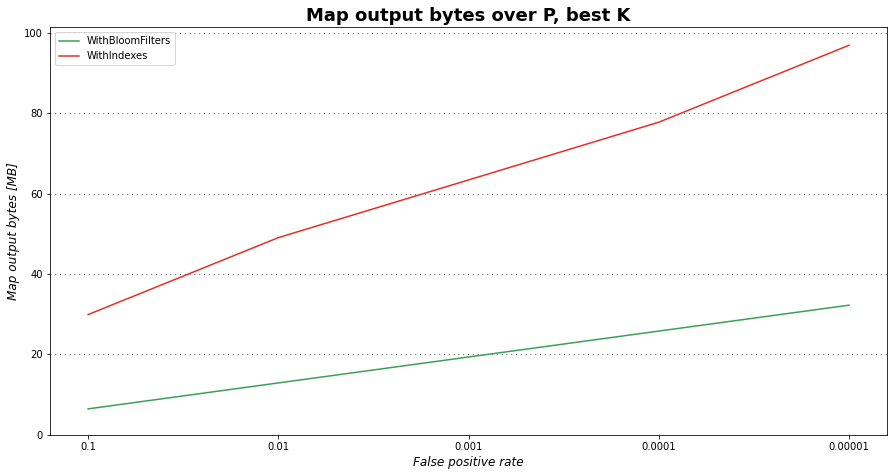

In [290]:
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']
K = ['0']
MAP = ['4', '6', '8', '10', '12']
MAP_P='0.001'
MAP_K='0'

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
data = bloom + indexes
legend = [f'{version}' for version in ['WithBloomFilters', 'WithIndexes']]

plot_data('MapOutputBytesP_bestK', P, data, legend, ['False positive rate', 'Map output bytes [MB]'], 
          title='Map output bytes over P, best K', colors=sns.color_palette('Greens_d', 1) + sns.color_palette('Reds_d', 1) )

* Map output bytes over M, best K

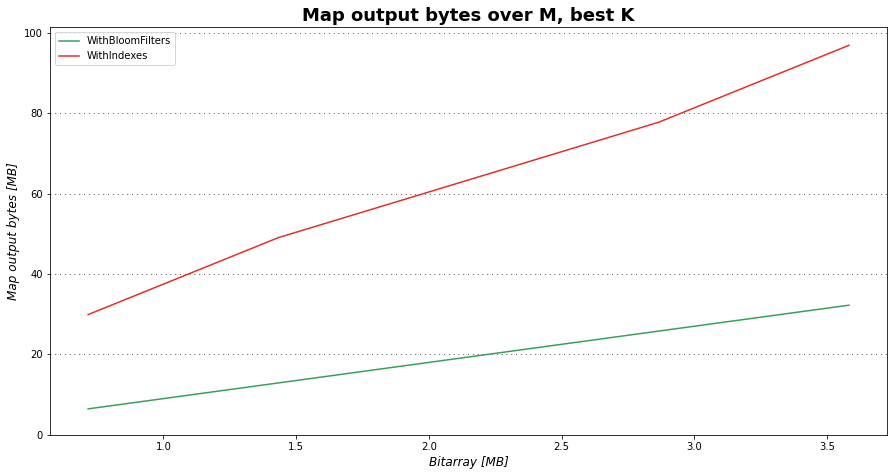

In [297]:
P = ['0.1', '0.01', '0.001', '0.0001', '0.00001']
K = ['0']
MAP = ['4', '6', '8', '10', '12']
MAP_P='0.001'
MAP_K='0'
M = [np.sum(m)/2**23 for m in [params[f'P{p}K0']['M'] for p in P]]

bloom = [[round(hadoop_aggregate[f'WithBloomFiltersP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
indexes = [[round(hadoop_aggregate[f'WithIndexesP{p}K{k}']['Map output bytes']['avg']/2**20, 2) for p in P] for k in K]
data = bloom + indexes
legend = [f'{version}' for version in ['WithBloomFilters', 'WithIndexes']]

plot_data('MapOutputBytesM_bestK', M, data, legend, ['Bitarray [MB]', 'Map output bytes [MB]'], 
          title='Map output bytes over M, best K', colors=sns.color_palette('Greens_d', 1) + sns.color_palette('Reds_d', 1))